In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [3]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [4]:
# First, we get the data
dataset = pd.read_csv('/content/AABA_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [5]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

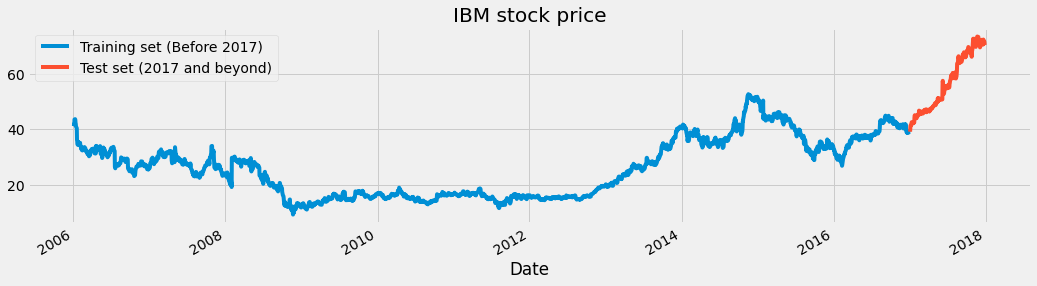

In [6]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [9]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

### 1. LSTM

In [20]:
# The LSTM architecture
regressor_ = Sequential()
# First LSTM layer with Dropout regularisation
regressor_.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor_.add(Dropout(0.2))
# Second LSTM layer
regressor_.add(LSTM(units=50, return_sequences=True))
regressor_.add(Dropout(0.2))
# Third LSTM layer
regressor_.add(LSTM(units=50, return_sequences=True))
regressor_.add(Dropout(0.2))
# Fourth LSTM layer
regressor_.add(LSTM(units=50))
regressor_.add(Dropout(0.2))
# The output layer
regressor_.add(Dense(units=1))

# Compiling the RNN
regressor_.compile(optimizer='rmsprop',loss='mean_squared_error')

regressor_.summary()

# Fitting to the training set
regressor_.fit(X_train,y_train,epochs=20,batch_size=32)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_19 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_28 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_20 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_29 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_21 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_30 (LSTM)              (None, 50)               

In [21]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [22]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor_.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

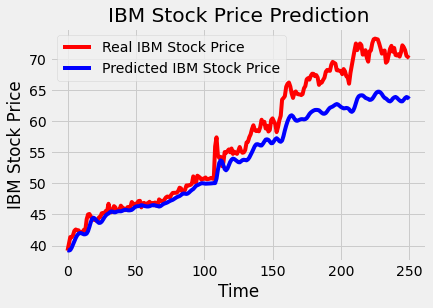

In [23]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [24]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 4.2681771165561875.


### 2. Stacked LSTM

In [25]:
# The LSTM architecture
regressor = Sequential()
# First stacked LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Second stacked LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third stacked LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

regressor.summary()

# Fitting to the training set
regressor.fit(X_train,y_train,epochs=20,batch_size=32)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_32 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_23 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_33 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_34 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_24 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_35 (LSTM)              (None, 60, 50)           

In [26]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [27]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

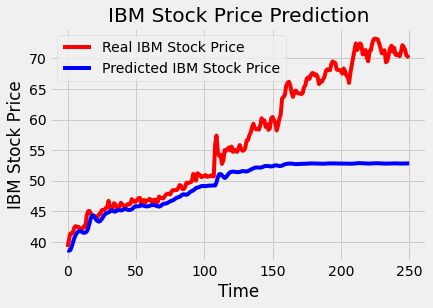

In [28]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [29]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 10.2226371736472.


### 3. Bidirectional LSTM

In [30]:
from tensorflow.keras.layers import Bidirectional

In [37]:
# The LSTM architecture
regressor_ = Sequential()
# First Bidirectional LSTM layer with Dropout regularisation
regressor_.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1],1)))
regressor_.add(Dropout(0.2))
# Second Bidirectional LSTM layer
regressor_.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressor_.add(Dropout(0.2))
# Third Bidirectional LSTM layer
regressor_.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressor_.add(Dropout(0.2))
# Fourth LSTM layer
regressor_.add(LSTM(units=50))
regressor_.add(Dropout(0.2))
# The output layer
regressor_.add(Dense(units=1))

# Compiling the RNN
regressor_.compile(optimizer='rmsprop',loss='mean_squared_error')

regressor_.build(input_shape=(X_train.shape[1],1))
regressor_.summary()

# Fitting to the training set
regressor_.fit(X_train,y_train,epochs=20,batch_size=32)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_13 (Bidirecti  (None, 60, 100)          20800     
 onal)                                                           
                                                                 
 dropout_51 (Dropout)        (None, 60, 100)           0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 60, 100)          60400     
 onal)                                                           
                                                                 
 dropout_52 (Dropout)        (None, 60, 100)           0         
                                                                 
 bidirectional_15 (Bidirecti  (None, 60, 100)          60400     
 onal)                                                           
                                                     

In [38]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [39]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor_.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

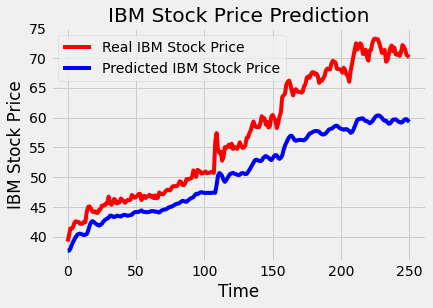

In [40]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [41]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 7.2183958394273535.


The LSTM showed an RMSE of around 4.5.
The Stacked LSTM showed an RMSE of around 10.
The Bidirectional LSTM showed an RMSE of 7.2.

It is usually expected that the stacked lstm will give a better accuracy than the normal lstm. However, this is not the case in this scenario. This needs to be further evaluated. The Bidirectional LSTM shows a better result than the stacked LSTM but still not as good as the basic LSTM. Is this the result of using dropout layers? Should that be tuned to get better understanding of the model and get better results? Atleast with the stacked LSTM and with the Bidirectional version this needs to be evaluated further and is my next direction of study.

GRU is also the next stage of study for me. However, I believe that it would have been too much of a leap in this case and I decided to study that going forward. 

LSTM's and in general RNN's and its various types have been very important learnings from this particular class and by extension this class activity.